<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Input" data-toc-modified-id="Input-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Input</a></span></li><li><span><a href="#Output" data-toc-modified-id="Output-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Output</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Parameters</a></span><ul class="toc-item"><li><span><a href="#Not-through-papermill" data-toc-modified-id="Not-through-papermill-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Not through papermill</a></span></li></ul></li><li><span><a href="#Load-Cell-Metadata" data-toc-modified-id="Load-Cell-Metadata-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load Cell Metadata</a></span></li><li><span><a href="#Basic-metrics-distribution" data-toc-modified-id="Basic-metrics-distribution-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Basic metrics distribution</a></span></li><li><span><a href="#Filter-by-basic-QC-metrics" data-toc-modified-id="Filter-by-basic-QC-metrics-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Filter by basic QC metrics</a></span></li><li><span><a href="#Other-Stats" data-toc-modified-id="Other-Stats-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Other Stats</a></span></li><li><span><a href="#Plateview-of-key-metrics" data-toc-modified-id="Plateview-of-key-metrics-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plateview of key metrics</a></span></li></ul></div>

# Basic Data Walkthrough and Cell Mapping Metric Filtering

## Purpose
- Overview of basic QC metrics per brain region
- Have a simple cell filtering based on basic QC metrics

## Input
- Cell metadata table

## Output
- Selected cell metadata table

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cemba_data.plot.preprocessing import cutoff_vs_cell_remain, plot_on_plate

In [3]:
result_dir = pathlib.Path()
fig_dir = result_dir / 'fig/cell_basic_qc'
fig_dir.mkdir(exist_ok=True, parents=True)

## Parameters

In [4]:
# parameters cell
study_name = ''

cell_metadata_path = ''

In [5]:
# Parameters
study_name = "5E"
cell_metadata_path = "/home/hanliu/project/mouse_rostral_brain/study/DissectionRegions/5E/CellMetadata.msg"


### Not through papermill

In [6]:
# QC metric filtering
qc_metric = {
    'CCC_Rate': (0, 0.05),
    'CG_RateAdj': (0.5, 1),
    'CH_RateAdj': (0., 0.15),
    'FinalReads': (500000, 10000000),
    'MappingRate': (0.5, 1)
}

# plot cell metadata columns
metadata_distribution_plot = {
    'CCC_Rate': (0., 0.1),
    'CH_RateAdj': (0, 0.1),
    'CG_RateAdj': (0.7, 0.9),
    'InputReads': (0, 1e7),
    'MappedReads': (0, 1e7),
    'FinalReads': (0, 1e7),
    'MappingRate': (0.5, 1)
}

final_reads_column = 'FinalReads'
plate_view = False

## Load Cell Metadata

In [7]:
total_cell_meta = pd.read_msgpack(cell_metadata_path)

In [8]:
cell_metadata_include = {}
cell_metadata_exclude = {}

# apply cell metadata and cell list selection first
judges = []
for k, v in cell_metadata_include.items():
    judges.append(total_cell_meta[k].isin(v))
for k, v in cell_metadata_exclude.items():
    judges.append(~total_cell_meta[k].isin(v))

if len(judges) != 0:
    cell_meta = total_cell_meta[np.all(judges, axis=0)].copy()
else:
    cell_meta = total_cell_meta

## Basic metrics distribution

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


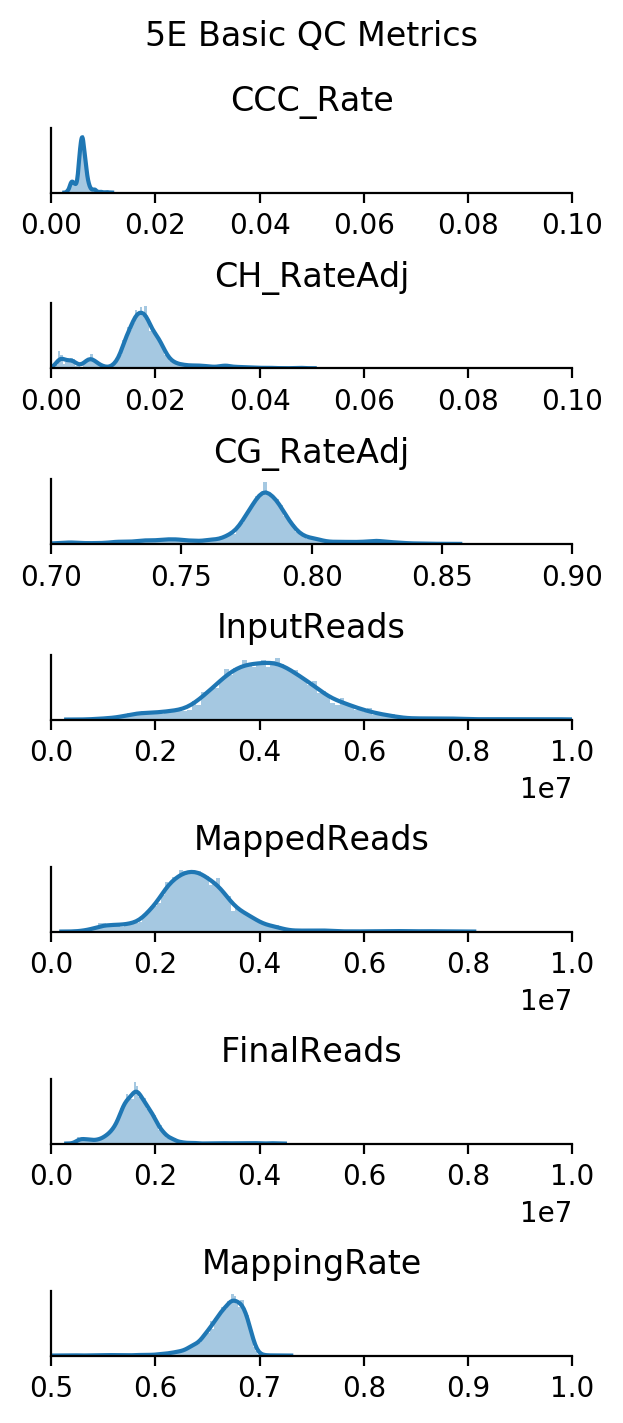

In [9]:
nrows = len(metadata_distribution_plot)
if nrows != 0:
    fig, axes = plt.subplots(nrows=nrows,
                             constrained_layout=True,
                             figsize=(3, nrows),
                             dpi=200)
    for (col, xlim), ax in zip(metadata_distribution_plot.items(), axes.flat):
        _data = cell_meta[col]
        _data = _data[(_data <= xlim[1]) & (_data >= xlim[0])]
        sns.distplot(_data, ax=ax, bins=100)
        ax.set(xlim=xlim, yticks=[], xlabel='', title=col)
    sns.despine(fig=fig, trim=True)

    fig.suptitle(f'{study_name} Basic QC Metrics')

    fig.savefig(fig_dir / f'basic_qc_metric.pdf')

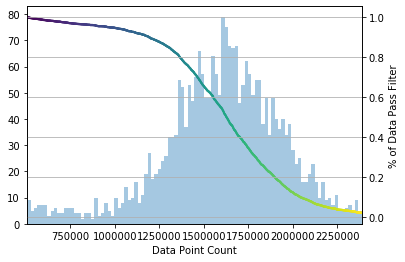

In [10]:
try:
    fig, axes = cutoff_vs_cell_remain(cell_meta[final_reads_column],
                                      xlim_quantile=(0.001, 0.98))
    fig.savefig(fig_dir / 'FinalReads distribution')
except KeyError:
    print(f'{final_reads_column} not in cell_meta, skip')

## Filter by basic QC metrics

In [11]:
judges = []
for col, (vmin, vmax) in qc_metric.items():
    judge = (cell_meta[col] >= vmin) & (cell_meta[col] <= vmax)
    print(
        f'{col} passed {judge.sum()}/{judge.size} ({(100*judge.sum()/judge.size):.1f}%)'
    )
    judges.append(judge)
cell_meta['PassFilter'] = np.all(judges, axis=0)

total_number = cell_meta['PassFilter'].sum()
print(
    f'Overall passed {total_number}/{judge.size} ({(100*total_number/cell_meta.shape[0]):.1f}%)'
)

CCC_Rate passed 2584/2584 (100.0%)
CG_RateAdj passed 2584/2584 (100.0%)
CH_RateAdj passed 2584/2584 (100.0%)
FinalReads passed 2584/2584 (100.0%)
MappingRate passed 2584/2584 (100.0%)
Overall passed 2584/2584 (100.0%)


In [12]:
cell_meta.to_msgpack('CellMetadata.AfterQC.msg')

## Other Stats

In [13]:
print('Cells pass basic QC in each batch:')
for k, v in cell_meta.groupby('FACS_Date')['PassFilter'].sum().astype(
        int).items():
    print(k, v)

Cells pass basic QC in each batch:
180925 1349
181206 1235


In [14]:
print('Cells pass basic QC in each random index:')
for k, v in cell_meta.groupby('index_name')['PassFilter'].sum().astype(
        int).items():
    print(k, v, f'{v/3.84:.1f}%')

Cells pass basic QC in each random index:
ad001 321 83.6%
ad002 322 83.9%
ad004 315 82.0%
ad006 324 84.4%
ad007 311 81.0%
ad008 331 86.2%
ad010 329 85.7%
ad012 331 86.2%


## Plateview of key metrics

In [15]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'FinalReads',
                              'Plate',
                              vmin=5e5,
                              vmax=3e6,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.FinalReads.pdf')

In [16]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CG_RateAdj',
                              'Plate',
                              vmin=0.65,
                              vmax=0.85,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CG_RateAdj.pdf')

In [17]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CH_RateAdj',
                              'Plate',
                              vmin=0,
                              vmax=0.05,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CH_RateAdj.pdf')

In [18]:
cell_meta

,AllcPath,CCC_Rate,CG_Rate,CG_RateAdj,CH_Rate,CH_RateAdj,FinalReads,InputReads,MappedReads,Region,...,l2-umap_0,l2-umap_1,l2-tsne_0,l2-tsne_1,SubType,l3-umap_0,l3-umap_1,l3-tsne_0,l3-tsne_1,PassFilter
5E_M_0,/gale/raidix/rdx-4/mapping/5E/CEMBA180925-5E-5...,0.005230,0.780050,0.778894,0.021271,0.016126,1798649.0,4320790,2941900.0,5E,...,9.379645,-6.612925,38.840705,23.941018,MSN-D2 Slc24a2,-2.450735,-0.600653,-23.963088,11.664728,True
5E_M_1,/gale/raidix/rdx-4/mapping/5E/CEMBA180925-5E-5...,0.006355,0.778787,0.777373,0.025048,0.018813,2471729.0,6134452,4140687.0,5E,...,-4.097778,-24.065863,66.070949,-11.116152,MSN-D1 Hrh1,-8.366325,10.307499,-25.843940,-27.118942,True
5E_M_10,/gale/raidix/rdx-4/mapping/5E/CEMBA180925-5E-5...,0.010928,0.841724,0.839976,0.058653,0.048252,1981957.0,5284666,3573338.0,5E,...,-10.573792,2.792208,-24.712609,26.013937,PAL-Inh Chat,-1.391052,11.862158,-13.708525,34.904755,True
5E_M_100,/gale/raidix/rdx-4/mapping/5E/CEMBA180925-5E-5...,0.005520,0.775427,0.774181,0.021320,0.015888,1712519.0,4506822,3116489.0,5E,...,3.934888,-1.568774,-12.482336,50.049759,Foxp2 Trpc7,-0.524299,-0.106489,7.792015,-13.562543,True
5E_M_1001,/gale/raidix/rdx-4/mapping/5E/CEMBA180925-5E-7...,0.005986,0.813053,0.811928,0.026694,0.020832,2357642.0,6629958,4339822.0,5E,...,-12.746385,4.999722,6.917484,64.492332,Chd7 Trpc7,10.420186,1.819713,-13.678858,-6.843144,True
5E_M_1002,/gale/raidix/rdx-4/mapping/5E/CEMBA180925-5E-7...,0.006266,0.775044,0.773626,0.025525,0.019380,1894978.0,5199168,3542006.0,5E,...,10.889285,-10.205695,45.238670,38.857546,MSN-D2 Slc24a2,-3.917226,5.305076,-4.050261,32.003302,True
5E_M_1003,/gale/raidix/rdx-4/mapping/5E/CEMBA180925-5E-7...,0.005416,0.777445,0.776234,0.020622,0.015290,1503072.0,4521818,2793067.0,5E,...,8.491580,-10.542269,27.323509,47.020124,MSN-D2 Col14a1,0.804879,4.014167,14.362948,16.681574,True
5E_M_1004,/gale/raidix/rdx-4/mapping/5E/CEMBA180925-5E-7...,0.006856,0.782417,0.780915,0.028321,0.021613,1881088.0,5108512,3512336.0,5E,...,-6.432498,-21.083818,44.675070,-23.995539,MSN-D1 Khdrbs3,-12.273337,7.763997,21.591451,-24.125142,True
5E_M_1005,/gale/raidix/rdx-4/mapping/5E/CEMBA180925-5E-7...,0.005661,0.783547,0.782314,0.022596,0.017032,1733181.0,4931106,3237616.0,5E,...,10.798092,-9.628719,44.003332,35.946937,MSN-D2 Slc24a2,-3.722172,3.545596,-0.020456,22.816576,True
5E_M_1008,/gale/raidix/rdx-4/mapping/5E/CEMBA180925-5E-7...,0.005776,0.780240,0.778963,0.024270,0.018601,1113622.0,3062888,1962813.0,5E,...,-1.910893,-21.131117,51.962545,0.097737,MSN-D1 Hrh1,-5.692207,5.351808,-14.656625,0.403018,True
